# Мобильная утилита для сканирования документов: расчет показателей эффективности LTV и ROMI


Приложение - мобильная утилита для сканирования документов. Модель монетизации 
подписочная, есть пробный период 7 дней с дальнейшим переходом в оплату 4.99 USD
в неделю. Предоставлена выгрузка из базы данных по оформлениям подписок и оплат. 
Каждая строка представляет собой отдельное событие (либо оформление пробной 
подписки, либо оплата после завершения пробного периода).

### Задачи
1. Рассчитать текущий LTV юзера, используя когортный анализ.
2. Спрогнозировать, каким будет LTV на полгода.
3. Построить график, который будет отображать кривую фактического LTV на фоне кривой прогнозируемого LTV.
4. Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения платящего пользователя 6 USD.

## Когортный анализ и расчет LTV юзера

### Исследовательский анализ данных

In [ ]:
# загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# открытие файла
data = pd.read_excel('test case data analyst.xlsx')

In [ ]:
# функция для изучения данных
def open_info(data):
    # вывод 5 строк данных
    print('*******************************************************')
    print('Представление датафрейма')
    display(data.head())
    print('*******************************************************')
    # вывод информации о датафрейме
    print('Общая информация о датафрейме')
    print('')
    print(data.info())
    print('*******************************************************')
    # проверка на наличие дубликатов
    print('Дубликаты:', data.duplicated().sum())
    print('*******************************************************')
    # проверка на наличие пропусков
    print('Пропуски:', data.isnull().sum())

In [ ]:
open_info(data)

*******************************************************
Представление датафрейма


,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657


*******************************************************
Общая информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114200 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       114200 non-null  object        
 1   quantity         114200 non-null  int64         
 2   is_trial_period  114200 non-null  bool          
 3   purchase_date    114200 non-null  datetime64[ns]
 4   user_id          114200 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 3.6+ MB
None
*******************************************************
Дубликаты: 84
*******************************************************
Пропуски: product_id         0
quantity           0
is_trial_period    0
purchase_date      0
user_id            0
dtype: int64


В датафрейме 114200 строк и 5 столбцов: product_id (код товара), quantity (количество приобретаемого товара), is_trial_period (столбец с отметкой о пробном периоде), purchase_date (дата либо оформления пробной подписки, либо подключения платной подписки, либо продления недельной платной подписки), user_id (номер пользователя). Пропусков нет. Обнаруживаются 84 дубликата.

#### Анализ дубликатов

In [ ]:
# срез с дупликатами
data1 = data[data.duplicated(keep=False)]
data1.head()

,product_id,quantity,is_trial_period,purchase_date,user_id
2955,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-04,9253232
3047,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-10,9443919
3075,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-12,8577778
3700,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-29,9061878
3707,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-24,8960121


In [ ]:
# вывод дублируемых строк по номеру пользователя
display(data1.query('user_id == 9253232'))
data1.query('user_id == 9443919')

,product_id,quantity,is_trial_period,purchase_date,user_id
2955,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-04,9253232
4557,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-04,9253232


,product_id,quantity,is_trial_period,purchase_date,user_id
3047,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-10,9443919
6224,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-10,9443919


Строки идентичны вплоть до совпадения id пользователя. Следовательно, можно удалить дубликаты.

In [ ]:
# удаление дубликатов
data_good = data.drop_duplicates(keep='first')
# проверка
data_good.duplicated().sum()

0

#### Анализ столбцов

##### Код товара

In [ ]:
# вывод значений столбца
data_good['product_id'].value_counts()

1week_4.99_USD_subscription_7days_trial    114116
Name: product_id, dtype: int64

В столбце только одно наименование, которое не имеет для дальнейшей работы информационной значимости, следовательно, его можно удалить.

In [ ]:
# удаление столбца
data_good = data_good.drop(['product_id'], axis=1)
# проверка
data_good.head(3)

,quantity,is_trial_period,purchase_date,user_id
0,1,False,2020-02-19,9484222
1,1,False,2020-02-17,9422402
2,1,False,2020-02-18,4997991


##### Количество приобретаемого товара

In [ ]:
# вывод значений столбца
data_good['quantity'].value_counts()

1    114116
Name: quantity, dtype: int64

Каждый раз пользователь приобретает один товар - пробную или платную подписку. Несмотря на то что информация содержится одна и та же, оставим столбец для дальнейших расчетов.

##### Столбец с отметкой о пробном периоде

In [ ]:
# вывод значений столбца
data_good['is_trial_period'].value_counts()

True     62944
False    51172
Name: is_trial_period, dtype: int64

Осуществим детальный анализ срезов по типу подписок, посмотрим, какое количество подписок оформляет каждый пользователь.

In [ ]:
# срез с пробной подпиской
data_false = data_good.query('is_trial_period == False')
# срез с платной подпиской
data_true = data_good.query('is_trial_period == True')

# вывод количества подписок по каждому пользователю в срезах
print('Пробная подписка')
display(data_true['user_id'].value_counts())
print('Платная подписка')
data_false['user_id'].value_counts()

Пробная подписка


8754110    2
8386661    2
8450945    2
9118299    2
8380316    2
          ..
9091975    1
9559653    1
9592850    1
8617917    1
8274954    1
Name: user_id, Length: 62909, dtype: int64

Платная подписка


8187292    7
8209764    7
8187277    7
8215000    7
8209067    7
          ..
9425853    1
9436829    1
9389906    1
9429972    1
9042479    1
Name: user_id, Length: 19546, dtype: int64

Как видим, некоторые пользователи могли повторно оформлять пробную подписку. По данным платной подписки можно отметить, что есть случаи как непродления платной подписки (платная подписка офорлена один раз), так и ее продление до 6 раз.

In [ ]:
data_good.query('user_id == 8187292')

,quantity,is_trial_period,purchase_date,user_id
277,1,False,2020-02-05,8187292
14410,1,False,2020-01-29,8187292
18158,1,False,2020-01-15,8187292
23238,1,False,2020-02-12,8187292
24552,1,False,2020-01-08,8187292
29054,1,False,2020-01-22,8187292
30369,1,False,2020-02-19,8187292
40598,1,True,2020-01-01,8187292


Здесь можно видеть, что пользователь оформил пробную подписку 1 января, через неделю оформил платную (т.е. тогда, когда истекла платная подписка) и потом продлевал подписку каждую неделю.

In [ ]:
data_good.query('user_id == 8754110')

,quantity,is_trial_period,purchase_date,user_id
58070,1,True,2020-01-12,8754110
105838,1,True,2020-01-17,8754110


Здесь мы видим, что у пользователя 12 января была оформлена пробная подписка, а потом еще 17 января. Видимо, такое возможно, но только в течение недельного периода. Как можно заметить, пользователь не приобретает в дальнейшем платную подписку.

Посмотрим, сколько таких пользователь с повторной пробной подпиской имеется.

In [ ]:
# список id пользователей из среза с данными по пробной подписке.
user_true_list_all = data_true['user_id'].tolist()

# подсчет повторений в списке
from collections import Counter
counter = Counter(user_true_list_all)
print(counter)

Counter({8386661: 2, 9118299: 2, 8812048: 2, 8916032: 2, 9135444: 2, 9287947: 2, 8608883: 2, 8376796: 2, 9421896: 2, 8450945: 2, 9059343: 2, 5627786: 2, 8311720: 2, 8934916: 2, 9126292: 2, 9428878: 2, 8380316: 2, 8955671: 2, 9249172: 2, 8801199: 2, 7149933: 2, 8754110: 2, 8211712: 2, 8845478: 2, 8724045: 2, 8644575: 2, 8735396: 2, 8882207: 2, 8538635: 2, 8498380: 2, 8796120: 2, 8366723: 2, 8629687: 2, 9474689: 2, 8215456: 2, 9429240: 1, 6629221: 1, 8428489: 1, 9294519: 1, 7611125: 1, 6702687: 1, 9157941: 1, 9365269: 1, 9430153: 1, 9547683: 1, 9120155: 1, 8745491: 1, 8834719: 1, 9290874: 1, 9314025: 1, 8590966: 1, 9038160: 1, 8816157: 1, 8885001: 1, 8118047: 1, 9114871: 1, 8992439: 1, 8795687: 1, 8678899: 1, 9090304: 1, 8914584: 1, 9088554: 1, 9120571: 1, 8754508: 1, 8829161: 1, 3740331: 1, 9121596: 1, 8770794: 1, 9343668: 1, 8341896: 1, 8856492: 1, 8709213: 1, 8615101: 1, 8547451: 1, 8339546: 1, 9041399: 1, 9345499: 1, 8857350: 1, 9317222: 1, 8960195: 1, 8299810: 1, 8718094: 1, 8273974

8386661, 9118299, 8812048, 8916032, 9135444, 9287947, 8608883, 8376796, 9421896, 8450945, 9059343, 5627786, 8311720, 8934916, 9126292, 9428878, 8380316, 8955671, 9249172, 8801199, 7149933, 8754110, 8211712, 8845478, 8724045, 8644575, 8735396, 8882207, 8538635, 8498380,
8796120, 8366723, 8629687, 9474689, 8215456 - вот эти пользователи оформляли повторную пробную подписку. Проанализируем данные по ним.

In [ ]:
# создание среза
data_true_repit = data_good.query('user_id == [8386661, 9118299, 8812048, 8916032, 9135444, 9287947, 8608883, 8376796, 9421896, 8450945, 9059343, 5627786, 8311720, 8934916, 9126292, 9428878, 8380316, 8955671, 9249172, 8801199, 7149933, 8754110, 8211712, 8845478, 8724045, 8644575, 8735396, 8882207, 8538635, 8498380, 8796120, 8366723, 8629687, 9474689, 8215456]')
data_true_repit

,quantity,is_trial_period,purchase_date,user_id
281,1,False,2020-02-17,9428878
2745,1,False,2020-02-02,8608883
8615,1,True,2020-01-19,8386661
9190,1,True,2020-01-31,9118299
9244,1,True,2020-02-07,9118299
...,...,...,...,...
109365,1,True,2020-01-05,8538635
110207,1,True,2020-02-12,9474689
110882,1,True,2020-01-09,8498380
111033,1,True,2020-01-02,8215456


Сразу же видим, что среди этих пользователей есть те, кто оформил платную подписку.

In [ ]:
data_true_repit['is_trial_period'].value_counts()

True     70
False    25
Name: is_trial_period, dtype: int64

In [ ]:
# сводная таблица по типу и количеству оформленных подписок
data_true_repit.groupby(['user_id','is_trial_period'])['quantity'].agg(['count'])

count
user_id is_trial_period       
5627786 True                 2
7149933 True                 2
8211712 False                5
        True                 2
8215456 True                 2
8311720 True                 2
8366723 True                 2
8376796 True                 2
8380316 True                 2
8386661 True                 2
8450945 True                 2
8498380 False                5
        True                 2
8538635 True                 2
8608883 False                5
        True                 2
8629687 True                 2
8644575 True                 2
8724045 True                 2
8735396 False                4
        True                 2
8754110 True                 2
8796120 True                 2
8801199 True                 2
8812048 True                 2
8845478 True                 2
8882207 True                 2
8916032 True                 2
8934916 True                 2
8955671 True                 2
9059343 True                 2
9118299 True                 2
9126292 False                2
        True                 2
9135444 True                 2
9249172 True                 2
9287947 False                1
        True                 2
9421896 False                2
        True                 2
9428878 False                1
        True                 2
9474689 True                 2

In [ ]:
data_good.query('user_id == 8211712').sort_values('purchase_date')

,quantity,is_trial_period,purchase_date,user_id
65446,1,True,2020-01-02,8211712
35692,1,False,2020-01-09,8211712
46034,1,False,2020-01-16,8211712
56030,1,False,2020-01-29,8211712
50941,1,False,2020-02-05,8211712
70151,1,False,2020-02-12,8211712
58854,1,True,2020-02-19,8211712


Видим, что пользователь оформил пробную подписку 2 января, после оформил платную, продлил ее 4 раза, а затем оформил опять пробную подписку. Здесь либо ошибка при сборе данных, и тогда 19 февраля пользователь просто продлил платную подписку. Либо пользователь нашел способ оформить повторно пробную подписку (нужно узнавать, возможно такое или нет). Решаем сделать здесь замену значения True на False, так как дата совпадает с датой очередного платежа.

In [ ]:
# замена значения
data_good.loc[(data_good['is_trial_period'] == True)&(data_good['user_id'] == 8211712)&(data_good['purchase_date'] == '2020-02-19'), 'is_trial_period'] = False
# проверка
data_good.query('user_id == 8211712').sort_values('purchase_date')

,quantity,is_trial_period,purchase_date,user_id
65446,1,True,2020-01-02,8211712
35692,1,False,2020-01-09,8211712
46034,1,False,2020-01-16,8211712
56030,1,False,2020-01-29,8211712
50941,1,False,2020-02-05,8211712
70151,1,False,2020-02-12,8211712
58854,1,False,2020-02-19,8211712


In [ ]:
data_good.query('user_id == 8608883').sort_values('purchase_date')

,quantity,is_trial_period,purchase_date,user_id
87389,1,True,2020-01-12,8608883
13488,1,True,2020-01-13,8608883
74422,1,False,2020-01-19,8608883
69161,1,False,2020-01-26,8608883
2745,1,False,2020-02-02,8608883
55460,1,False,2020-02-09,8608883
40729,1,False,2020-02-16,8608883


В этом случае видим, что пользователь оформил два раза пробную подписку с разницей в один день, затем оформил платную и продлевал ее каждую неделю.

Можно сделать вывод, что офомление повторной пробной подписки возможно в течение недели, пока пробная подписка не сгорит, платная подписка оформляется с отчетом от даты первой пробной подписки.

Здесь можно удалить строку с повторной пробной подпиской.

In [ ]:
# удаление строки
data_good.drop(index = 13488, inplace = True)
# проверка
data_good.query('user_id == 8608883').sort_values('purchase_date')

,quantity,is_trial_period,purchase_date,user_id
87389,1,True,2020-01-12,8608883
74422,1,False,2020-01-19,8608883
69161,1,False,2020-01-26,8608883
2745,1,False,2020-02-02,8608883
55460,1,False,2020-02-09,8608883
40729,1,False,2020-02-16,8608883


Отберем отдельно данные по пользователям, оформлявшим платную подписку.

In [ ]:
# срез
user_false_mistake = data_true_repit.query('is_trial_period == False')['user_id'].unique().tolist()
user_false_mistake

[9428878, 8608883, 9421896, 9287947, 8735396, 8211712, 8498380, 9126292]

Поскольку таких пользователей всего 8 (данные по двум из них обработаны выше: 8211712, 8608883), можем отобрать аномальные значения вручную.

In [ ]:
display(data_true_repit.query('user_id == 9428878').sort_values('purchase_date'))
display(data_true_repit.query('user_id == 9421896').sort_values('purchase_date'))
display(data_true_repit.query('user_id == 9287947').sort_values('purchase_date'))
display(data_true_repit.query('user_id == 8735396').sort_values('purchase_date'))
display(data_true_repit.query('user_id == 8498380').sort_values('purchase_date'))
data_true_repit.query('user_id == 9126292').sort_values('purchase_date')

,quantity,is_trial_period,purchase_date,user_id
39574,1,True,2020-02-10,9428878
27492,1,True,2020-02-13,9428878
281,1,False,2020-02-17,9428878


,quantity,is_trial_period,purchase_date,user_id
29878,1,True,2020-02-04,9421896
16470,1,True,2020-02-10,9421896
15144,1,False,2020-02-11,9421896
73322,1,False,2020-02-18,9421896


,quantity,is_trial_period,purchase_date,user_id
78663,1,True,2020-02-05,9287947
11534,1,True,2020-02-06,9287947
30001,1,False,2020-02-12,9287947


,quantity,is_trial_period,purchase_date,user_id
69712,1,True,2020-01-17,8735396
93405,1,True,2020-01-23,8735396
82166,1,False,2020-01-24,8735396
35342,1,False,2020-01-31,8735396
43899,1,False,2020-02-07,8735396
45060,1,False,2020-02-14,8735396


,quantity,is_trial_period,purchase_date,user_id
110882,1,True,2020-01-09,8498380
97185,1,False,2020-01-16,8498380
38513,1,False,2020-01-23,8498380
96354,1,False,2020-01-30,8498380
74879,1,True,2020-02-05,8498380
42875,1,False,2020-02-12,8498380
52897,1,False,2020-02-19,8498380


,quantity,is_trial_period,purchase_date,user_id
34195,1,True,2020-02-01,9126292
26690,1,True,2020-02-03,9126292
60696,1,False,2020-02-08,9126292
84507,1,False,2020-02-15,9126292


In [ ]:
# удаление строки
data_good.drop(index = 27492, inplace = True)
data_good.drop(index = 16470, inplace = True)
data_good.drop(index = 11534, inplace = True)
data_good.drop(index = 93405, inplace = True)
data_good.drop(index = 26690, inplace = True)
# замена значения
data_good.loc[(data_good['is_trial_period'] == True)&(data_good['user_id'] == 8498380)&(data_good['purchase_date'] == '2020-02-05'), 'is_trial_period'] = False

Теперь отберем отдельно данные по пользователям, оформлявшим только пробную подписку, но повторно.

In [ ]:
# срез
user_true_mistake = data_true_repit.query('is_trial_period == True')
user_true_mistake

# удаление лишних столбцов
user_true_mistake = user_true_mistake.drop(['is_trial_period', 'quantity'], axis=1)
user_true_mistake

# удаление данных по пользователям, обработанных ранее
user_true_mistake = user_true_mistake.query('user_id != [9428878, 8608883, 9421896, 9287947, 8735396, 8211712, 8498380, 9126292]')

# выделение первой и второй даты
mistake = user_true_mistake.groupby(by ='user_id').agg(['min', 'max'])
# переименование столбцов
mistake.columns = mistake.columns.droplevel()
mistake.columns = ['first', 'second']
mistake = mistake[['first', 'second']]
# расчет временного промежутка между второй и первой датой
mistake['result'] = mistake['second'] - mistake['first']
mistake

,first,second,result
user_id,,,
5627786,2020-01-28,2020-02-06,9 days
7149933,2020-01-04,2020-01-05,1 days
8215456,2020-01-02,2020-01-04,2 days
8311720,2020-01-04,2020-01-07,3 days
8366723,2020-01-05,2020-01-06,1 days
8376796,2020-01-05,2020-01-06,1 days
8380316,2020-01-06,2020-01-08,2 days
8386661,2020-01-17,2020-01-19,2 days
8450945,2020-01-08,2020-01-14,6 days


Теперь можно определить, где данные по повторному пробному периоду и их можно удалить, а где данные уже по платной подписке, в этом случае в основной таблице делаем замену True на False.

Для начала изменим тип данных столбца result. После создадим два списка с id пользователей: первый с теми, данные по которым нужно удалить, второй с теми, данные по которым требуют корректировки.

In [ ]:
# замена типа данных
mistake['result'] = mistake['result'].dt.days.astype('int')
mistake

,first,second,result
user_id,,,
5627786,2020-01-28,2020-02-06,9
7149933,2020-01-04,2020-01-05,1
8215456,2020-01-02,2020-01-04,2
8311720,2020-01-04,2020-01-07,3
8366723,2020-01-05,2020-01-06,1
8376796,2020-01-05,2020-01-06,1
8380316,2020-01-06,2020-01-08,2
8386661,2020-01-17,2020-01-19,2
8450945,2020-01-08,2020-01-14,6


In [ ]:
# создание списков
false_user = mistake.query('result < 7').index.tolist()
print(false_user)
true_user = mistake.query('result == 7 or result > 7').index.tolist()
print(true_user)

[7149933, 8215456, 8311720, 8366723, 8376796, 8380316, 8386661, 8450945, 8538635, 8724045, 8754110, 8796120, 8801199, 8812048, 8845478, 8916032, 8934916, 8955671, 9059343, 9135444, 9249172, 9474689]
[5627786, 8629687, 8644575, 8882207, 9118299]


In [ ]:
# срез по списку true_user
data_good.query('user_id == [5627786, 8629687, 8644575, 8882207, 9118299]').sort_values('user_id')

,quantity,is_trial_period,purchase_date,user_id
19699,1,True,2020-02-06,5627786
77828,1,True,2020-01-28,5627786
83429,1,True,2020-01-14,8629687
89560,1,True,2020-01-21,8629687
68542,1,True,2020-02-02,8644575
86435,1,True,2020-01-14,8644575
70842,1,True,2020-02-04,8882207
101184,1,True,2020-01-22,8882207
9190,1,True,2020-01-31,9118299
9244,1,True,2020-02-07,9118299


In [ ]:
# замена значения
data_good.loc[(data_good['is_trial_period'] == True)&(data_good['user_id'] == 5627786)&(data_good['purchase_date'] == '2020-02-06'), 'is_trial_period'] = False
data_good.loc[(data_good['is_trial_period'] == True)&(data_good['user_id'] == 8629687)&(data_good['purchase_date'] == '2020-01-21'), 'is_trial_period'] = False
data_good.loc[(data_good['is_trial_period'] == True)&(data_good['user_id'] == 8644575)&(data_good['purchase_date'] == '2020-02-02'), 'is_trial_period'] = False
data_good.loc[(data_good['is_trial_period'] == True)&(data_good['user_id'] == 8882207)&(data_good['purchase_date'] == '2020-02-04'), 'is_trial_period'] = False
data_good.loc[(data_good['is_trial_period'] == True)&(data_good['user_id'] == 9118299)&(data_good['purchase_date'] == '2020-02-07'), 'is_trial_period'] = False
# проверка
data_good.query('user_id == [5627786, 8629687, 8644575, 8882207, 9118299]').sort_values('user_id')

,quantity,is_trial_period,purchase_date,user_id
19699,1,False,2020-02-06,5627786
77828,1,True,2020-01-28,5627786
83429,1,True,2020-01-14,8629687
89560,1,False,2020-01-21,8629687
68542,1,False,2020-02-02,8644575
86435,1,True,2020-01-14,8644575
70842,1,False,2020-02-04,8882207
101184,1,True,2020-01-22,8882207
9190,1,True,2020-01-31,9118299
9244,1,False,2020-02-07,9118299


In [ ]:
# срез по списку false_user
data_good.query('user_id == [7149933, 8215456, 8311720, 8366723, 8376796, 8380316, 8386661, 8450945, 8538635, 8724045, 8754110, 8796120, 8801199, 8812048, 8845478, 8916032, 8934916, 8955671, 9059343, 9135444, 9249172, 9474689]').sort_values('user_id')

,quantity,is_trial_period,purchase_date,user_id
91973,1,True,2020-01-04,7149933
49691,1,True,2020-01-05,7149933
111293,1,True,2020-01-04,8215456
111033,1,True,2020-01-02,8215456
74719,1,True,2020-01-04,8311720
20781,1,True,2020-01-07,8311720
98967,1,True,2020-01-05,8366723
79703,1,True,2020-01-06,8366723
15885,1,True,2020-01-06,8376796
19454,1,True,2020-01-05,8376796


В данном случае у нас имеются данные по пользователям, которые не оформляли платную подписку. Считаем, что можно для каждого пользователя удалить одну из повторяющихся строк, не выбирая, какая из дат позже.

In [ ]:
# удаление строк
data_good = data_good[~((data_good.duplicated(['is_trial_period', 'user_id']))&(data_good.is_trial_period==True))]
# проверка
data_good.query('user_id == 9474689')

,quantity,is_trial_period,purchase_date,user_id
98382,1,True,2020-02-11,9474689


##### Даты оформления подписки

In [ ]:
data_good['purchase_date'].value_counts()

2020-02-13    3342
2020-02-12    3320
2020-02-19    3198
2020-02-14    3106
2020-02-06    3060
2020-02-05    3047
2020-02-07    3011
2020-02-17    2979
2020-02-18    2902
2020-02-11    2876
2020-02-10    2871
2020-01-30    2752
2020-01-31    2736
2020-02-03    2689
2020-02-04    2664
2020-02-16    2607
2020-01-29    2581
2020-02-15    2484
2020-02-09    2451
2020-01-23    2444
2020-01-24    2375
2020-01-22    2374
2020-02-08    2341
2020-02-01    2311
2020-02-02    2278
2020-01-27    2263
2020-01-16    2251
2020-01-28    2236
2020-01-21    2221
2020-01-17    2141
2020-01-20    2133
2020-01-15    2056
2020-01-19    2001
2020-01-26    1975
2020-01-25    1935
2020-01-18    1918
2020-01-13    1914
2020-01-14    1795
2020-01-11    1756
2020-01-10    1748
2020-01-12    1724
2020-01-09    1673
2020-01-05    1523
2020-01-04    1457
2020-01-08    1446
2020-01-03    1439
2020-01-06    1361
2020-01-02    1300
2020-01-07    1192
2020-02-20     925
2020-01-01     906
Name: purchase_date, dtype: int

Больше всего подписок было оформлено  13 и 12 февраля. Меньше всего - 1 и 20 января.

In [ ]:
data_good['purchase_date'].sort_values()

81146    2020-01-01
113490   2020-01-01
86662    2020-01-01
113489   2020-01-01
58412    2020-01-01
            ...    
25926    2020-02-20
25960    2020-02-20
4263     2020-02-20
35496    2020-02-20
46233    2020-02-20
Name: purchase_date, Length: 114088, dtype: datetime64[ns]

Данные представлены за период с 1 января по 20 февраля.

##### Данные по пользователям

In [ ]:
data_good['user_id'].value_counts()

8211929    8
8210958    8
8207674    8
8200091    8
1279634    8
          ..
8424973    1
9589751    1
9533118    1
9526414    1
8274954    1
Name: user_id, Length: 62909, dtype: int64

В таблице представлены данные по 62909 пользователям, оформлявшим либо только пробную подписку, либо пробную и платную от 1 до 7 раз.

#### Вывод

<div style="border-radius: 15px; border: 3px solid green; padding: 15px;">

**Общая информация**  
Данные по подписке на мобильную утилиту для сканирования документов представлены за период с 1 января по 20 февраля. Имеется информация по 62909 пользователям. Известно, что часть из них оформляла только пробную подписку, часть оформляла платную подписку, но не продлевала ее, часть продлевала от 1 до 6 раз.

**Дубликаты и пропуски**  
В данных были обнаружены 84 дубликата. Удалены. Пропусков нет.
    
**Аномальные значения**  
Были обнаружены несостыковки в данных по оформлению пробной и платной подписки. Все несостыковки устранены либо за счет удаления повторных пробных подписок (в случаях, когда разница между данными составляла меньше 7 дней), либо за счет изменения данных в столбце по типу подписки (в частности, были изменены сведения в тех случаях, когда по срокам уже не могла быть оформлена пробная подписка).

### Построение когорт

Построем две матрицы когорт. Одну с количеством сделанных подписок, другую с оплатой за подписку.

Создадим столбец со стоимостью подписки.

In [ ]:
# создание столбца
data_good['sales'] = 4.99
data_good.head()

,quantity,is_trial_period,purchase_date,user_id,sales
0,1,False,2020-02-19,9484222,4.99
1,1,False,2020-02-17,9422402,4.99
2,1,False,2020-02-18,4997991,4.99
3,1,False,2020-02-18,9455582,4.99
4,1,False,2020-02-16,8803657,4.99


Внесем в созданный столбец нулевые значения для пробной подписки.

In [ ]:
# замена значения по условию
data_good.loc[(data_good['is_trial_period']==True), 'sales'] = 0
# проверка
data_good.query('user_id == 8196165')

,quantity,is_trial_period,purchase_date,user_id,sales
43619,1,False,2020-01-08,8196165,4.99
45185,1,False,2020-01-29,8196165,4.99
54177,1,False,2020-01-15,8196165,4.99
55637,1,False,2020-02-12,8196165,4.99
61107,1,False,2020-01-22,8196165,4.99
62748,1,True,2020-01-01,8196165,0.00
83087,1,False,2020-02-19,8196165,4.99
85279,1,False,2020-02-05,8196165,4.99


Сгруппируем пользователей по количеству оформленных подписок и по дате оформления пробной подписки.

In [ ]:
# таблица с информацией о количестве подписок и суммой оплаты 
data_sum = data_good.groupby('user_id')['sales'].agg(['sum', 'count'])

# таблица с данными о дне оформления пробной подписки
first_date = data_good.groupby('user_id')['purchase_date'].agg(['min'])
first_date.columns = ['first_date']
first_date = first_date[['first_date']]

# объединение таблиц
data_merged = data_sum.merge(first_date, how='inner', left_on='user_id', right_index=True)

# сводная таблица по дате пробной подписки и количеству подписок (количество подписок)
df_count = data_merged.pivot_table(
                 index='first_date',
                 #values='count',
                 columns='count', aggfunc = 'count')
df_count
df_count.columns = df_count.columns.droplevel()
df_count.columns = ['1', '2', '3', '4', '5', '6', '7', '8']
df_count = df_count[['1', '2', '3', '4', '5', '6', '7', '8']]

# сводная таблица по дате пробной подписки и количеству подписок (доходы)
df_sum = data_merged.pivot_table(
                 index='first_date',
                 values='sum',
                 columns='count', aggfunc = ['sum'])

df_sum.columns = df_sum.columns.droplevel()
df_sum.columns = ['1', '2', '3', '4', '5', '6', '7', '8']
df_sum = df_sum[['1', '2', '3', '4', '5', '6', '7', '8']]

display(df_sum)
df_count


,1,2,3,4,5,6,7,8
first_date,,,,,,,,
2020-01-01,0.0,344.31,429.14,523.95,518.96,598.80,838.32,5064.85
2020-01-02,0.0,523.95,908.18,703.59,978.04,823.35,4790.40,2200.59
2020-01-03,0.0,593.81,778.44,763.47,1117.76,1397.20,6556.86,NaN
2020-01-04,0.0,723.55,818.36,1062.87,1077.84,1372.25,6916.14,NaN
2020-01-05,0.0,698.60,688.62,1257.48,1197.60,1272.45,7724.52,NaN
2020-01-06,0.0,648.70,738.52,973.05,758.48,848.30,6047.88,NaN
2020-01-07,0.0,533.93,658.68,853.29,898.20,823.35,4970.04,NaN
2020-01-08,0.0,449.10,578.84,808.38,638.72,923.15,4940.10,NaN
2020-01-09,0.0,484.03,718.56,673.65,698.60,3268.45,1586.82,NaN


,1,2,3,4,5,6,7,8
first_date,,,,,,,,
2020-01-01,536.0,69.0,43.0,35.0,26.0,24.0,28.0,145.0
2020-01-02,752.0,105.0,91.0,47.0,49.0,33.0,160.0,63.0
2020-01-03,860.0,119.0,78.0,51.0,56.0,56.0,219.0,NaN
2020-01-04,819.0,145.0,82.0,71.0,54.0,55.0,231.0,NaN
2020-01-05,861.0,140.0,69.0,84.0,60.0,51.0,258.0,NaN
2020-01-06,818.0,130.0,74.0,65.0,38.0,34.0,202.0,NaN
2020-01-07,717.0,107.0,66.0,57.0,45.0,33.0,166.0,NaN
2020-01-08,690.0,90.0,58.0,54.0,32.0,37.0,165.0,NaN
2020-01-09,771.0,97.0,72.0,45.0,35.0,131.0,53.0,NaN


Таким образом, получилась таблица с данными по 51 когорте, сгруппированной по дате оформления подписки. Есть данные как по пользователям, оформившим только пробную подписку (столбец 1), так и по тем, кто совершил от 1 до 7 оплат за подписку. Здесь данные по каждой когорте даны по неделям, т.е. мы можем узнать, сколько пользователей из первой когорты продлили подписку после первого платежа и т.д.

### Расчет LTV

In [ ]:
# расчет кумулятивной суммы
df_cumsum = np.cumsum(df_sum, axis=1)
df_cumcount = np.cumsum(df_count, axis=1)

display(df_cumsum)
df_cumcount

,1,2,3,4,5,6,7,8
first_date,,,,,,,,
2020-01-01,0.0,344.31,773.45,1297.40,1816.36,2415.16,3253.48,8318.33
2020-01-02,0.0,523.95,1432.13,2135.72,3113.76,3937.11,8727.51,10928.10
2020-01-03,0.0,593.81,1372.25,2135.72,3253.48,4650.68,11207.54,NaN
2020-01-04,0.0,723.55,1541.91,2604.78,3682.62,5054.87,11971.01,NaN
2020-01-05,0.0,698.60,1387.22,2644.70,3842.30,5114.75,12839.27,NaN
2020-01-06,0.0,648.70,1387.22,2360.27,3118.75,3967.05,10014.93,NaN
2020-01-07,0.0,533.93,1192.61,2045.90,2944.10,3767.45,8737.49,NaN
2020-01-08,0.0,449.10,1027.94,1836.32,2475.04,3398.19,8338.29,NaN
2020-01-09,0.0,484.03,1202.59,1876.24,2574.84,5843.29,7430.11,NaN


,1,2,3,4,5,6,7,8
first_date,,,,,,,,
2020-01-01,536.0,605.0,648.0,683.0,709.0,733.0,761.0,906.0
2020-01-02,752.0,857.0,948.0,995.0,1044.0,1077.0,1237.0,1300.0
2020-01-03,860.0,979.0,1057.0,1108.0,1164.0,1220.0,1439.0,NaN
2020-01-04,819.0,964.0,1046.0,1117.0,1171.0,1226.0,1457.0,NaN
2020-01-05,861.0,1001.0,1070.0,1154.0,1214.0,1265.0,1523.0,NaN
2020-01-06,818.0,948.0,1022.0,1087.0,1125.0,1159.0,1361.0,NaN
2020-01-07,717.0,824.0,890.0,947.0,992.0,1025.0,1191.0,NaN
2020-01-08,690.0,780.0,838.0,892.0,924.0,961.0,1126.0,NaN
2020-01-09,771.0,868.0,940.0,985.0,1020.0,1151.0,1204.0,NaN


Теперь можно видеть общее количество пользователей по каждой когорте, доход, который они приносят после каждого продления подписки. Можно посмотреть общий доход за два месяца и количество привлеченных пользователей.

Сделаем расчет LTV для каждой когорты на каждую неделю.

In [ ]:
df_ltv = df_cumsum / df_cumcount
df_ltv

,1,2,3,4,5,6,7,8
first_date,,,,,,,,
2020-01-01,0.0,0.569107,1.193596,1.899561,2.561862,3.294898,4.275269,9.181380
2020-01-02,0.0,0.611377,1.510686,2.146452,2.982529,3.655627,7.055384,8.406231
2020-01-03,0.0,0.606547,1.298250,1.927545,2.795086,3.812033,7.788423,NaN
2020-01-04,0.0,0.750571,1.474101,2.331943,3.144851,4.123059,8.216205,NaN
2020-01-05,0.0,0.697902,1.296467,2.291768,3.164992,4.043281,8.430250,NaN
2020-01-06,0.0,0.684283,1.357358,2.171362,2.772222,3.422821,7.358508,NaN
2020-01-07,0.0,0.647973,1.340011,2.160401,2.967843,3.675561,7.336264,NaN
2020-01-08,0.0,0.575769,1.226659,2.058655,2.678615,3.536098,7.405231,NaN
2020-01-09,0.0,0.557638,1.279351,1.904812,2.524353,5.076707,6.171188,NaN


Полученная таблица позволяет увидеть как текущий LTV юзера, так и LTV на каждом этапе жизни той или иной когорты. Так, например, текущий LTV юзеров, оформивших временную подписку 1 января составляет 9.18, неделю ранее у той же когорты LTV был равен 4.27. Т.е. можно заметить, как растет LTV когорт пользователей, привлеченных в разное время. Для наглядности можно представить информацию на графиках.

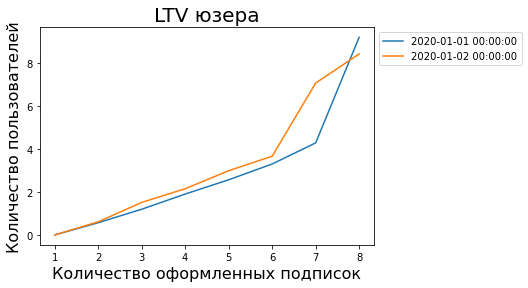

In [ ]:
df_ltv_other = df_ltv.T
# график
df_ltv_other[['2020-01-01', '2020-01-02']].plot()
plt.xlabel('Количество оформленных подписок', fontsize=16)
plt.ylabel('Количество пользователей', fontsize=16)
plt.title('LTV юзера', fontsize=20)
plt.legend(bbox_to_anchor=(1, 1))

На этом графике мы видим, как отличается рост LTV юзеров, оформивших подписку 1 января и 2 января 2020 г. Резкий рост LTV пользователей, оформивших подписку 2 января, начинается после 5 платной подписки, для юзером, оформивших подписку 1 января, - после 6 подписки, т.е. на неделю позже.

Посмотрим на динамику LTV по когортам, появившимся с разницой в неделю, а также отобразим на графике все исследуемые когорты.

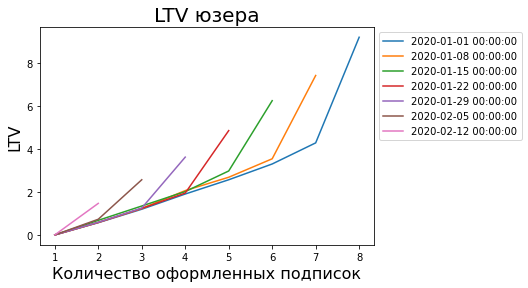

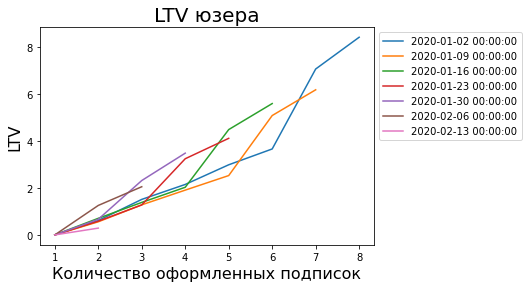

In [ ]:
# график
df_ltv_other[['2020-01-01', '2020-01-08', '2020-01-15', '2020-01-22', '2020-01-29',
       '2020-02-05', '2020-02-12']].plot()
plt.xlabel('Количество оформленных подписок', fontsize=16)
plt.ylabel('LTV', fontsize=16)
plt.title('LTV юзера', fontsize=20)
plt.legend(bbox_to_anchor=(1, 1))

# график
import matplotlib.pyplot as plt
df_ltv_other[['2020-01-02', '2020-01-09', '2020-01-16', '2020-01-23', '2020-01-30',
       '2020-02-06', '2020-02-13']].plot()
plt.xlabel('Количество оформленных подписок', fontsize=16)
plt.ylabel('LTV', fontsize=16)
plt.title('LTV юзера', fontsize=20)
plt.legend(bbox_to_anchor=(1, 1));


Как можно заметить, чем "моложе" когорта, тем резкий рост LTV происходит раньше. Так если первая когорта имеет LTV = 4.27 на момент 6 платной подписки, то тот же уровень LTV имеется у ряда когорт уже на момент 3 или 4 платной подписки (см. когорты 2020-01-24 и 2020-01-16).

Далее спрогнозируем, каким будет LTV на полгода для первой и второй когорт.

## Прогнозирование LTV

Прогнозирование LTV можно сделать с помощью линейной регрессии, но за основу брать не данные по LTV. Предполагается сначала спрогнозировать доход и количество клиентов на полгода и уже на этих данных рассчитать LTV на полгода.

### Прогнозирование дохода

Когорта 2020-01-01
Наклон: 931.1696428571432
Перехват: -1912.9521428571447
****************************************************
Когорта 2020-01-02
Наклон: 1500.0890476190482
Перехват: -2900.615714285717


,1,2,3,4,5,6,7,8,12,16,20,24
first_date,,,,,,,,,,,,
2020-01-01,0.0,344.31,773.45,1297.40,1816.36,2415.16,3253.48,8318.33,11123.422857,12985.762143,16710.440714,20435.119286
2020-01-02,0.0,523.95,1432.13,2135.72,3113.76,3937.11,8727.51,10928.10,15100.452857,21100.809048,27101.165238,33101.521429


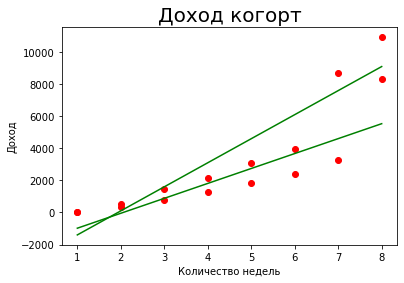

In [ ]:
# срез данных по доходам по первым двум когортам
df_cumsum_8 = df_cumsum.dropna(axis=0)
df_cumsum_8_other = df_cumsum_8.T
df_cumsum_8_other


# линейная регрессия для первой когорты
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y = np.array(df_cumsum_8_other['2020-01-01'])
n = np.size(x)
x_mean = np.mean(x)
y_mean = np.mean(y)
x_mean, y_mean
Sxy = np. sum (x * y) - n * x_mean * y_mean
Sxx = np. sum (x * x) - n * x_mean * x_mean
b1 = Sxy / Sxx
b0 = y_mean - b1 * x_mean

y_pred = b1 * x + b0
plt.scatter(x, y, color = 'red' )
plt.plot(x, y_pred, color = 'green' )
plt.xlabel( 'Количество недель' )
plt.ylabel( 'Доход' )
plt.title('Доход когорт', fontsize=20);

print('Когорта 2020-01-01')
print('Наклон:', b1)
print('Перехват:', b0)


# линейная регрессия для второй когорты
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y = np.array(df_cumsum_8_other['2020-01-02'])
n = np.size(x)
x_mean = np.mean(x)
y_mean = np.mean(y)
x_mean, y_mean
Sxy = np. sum (x * y) - n * x_mean * y_mean
Sxx = np. sum (x * x) - n * x_mean * x_mean
t1 = Sxy / Sxx
t0 = y_mean - t1 * x_mean

y_pred = t1 * x + t0
plt.scatter(x, y, color = 'red' )
plt.plot(x, y_pred, color = 'green' )
plt.xlabel( 'Количество недель' )
plt.ylabel( 'Доход' )
plt.title('Доход когорт', fontsize=20);

print('****************************************************')
print('Когорта 2020-01-02')
print ('Наклон:', t1)
print ('Перехват:', t0)


# расчет дохода на 3, 4, 5 и 6 месяцев
df_cumsum_8['12']=b1 * 14 + b0
df_cumsum_8.loc[(df_cumsum_8.index == '2020-01-02'), '12'] = (t1 * 12 + t0)
df_cumsum_8['16']=b1 * 16 + b0
df_cumsum_8.loc[(df_cumsum_8.index == '2020-01-02'), '16'] = (t1 * 16 + t0)
df_cumsum_8['20']=b1 * 20 + b0
df_cumsum_8.loc[(df_cumsum_8.index == '2020-01-02'), '20'] = (t1 * 20 + t0)
df_cumsum_8['24']=b1 * 24 + b0
df_cumsum_8.loc[(df_cumsum_8.index == '2020-01-02'), '24'] = (t1 * 24 + t0)
df_cumsum_8

### Прогнозирование количества пользователей

Когорта 2020-01-01
Наклон: 43.464285714285715
Перехват: 502.0357142857143
****************************************************
Когорта 2020-01-02
Наклон: 73.47619047619048
Перехват: 695.6071428571429


,1,2,3,4,5,6,7,8,12,16,20,24
first_date,,,,,,,,,,,,
2020-01-01,536.0,605.0,648.0,683.0,709.0,733.0,761.0,906.0,1023.607143,1197.464286,1371.321429,1545.178571
2020-01-02,752.0,857.0,948.0,995.0,1044.0,1077.0,1237.0,1300.0,1577.321429,1871.226190,2165.130952,2459.035714


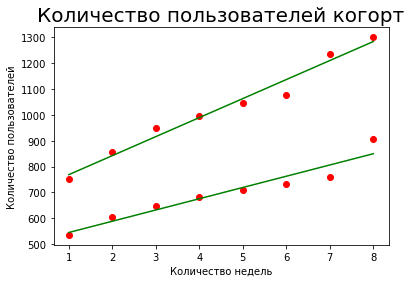

In [ ]:
# срез данных по количеству пользователей по первым двум когортам
df_cumcount_8 = df_cumcount.dropna(axis=0)
df_cumcount_8_other = df_cumcount_8.T
df_cumcount_8_other


# линейная регрессия для первой когорты
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y = np.array(df_cumcount_8_other['2020-01-01'])
n = np.size(x)
x_mean = np.mean(x)
y_mean = np.mean(y)
x_mean, y_mean
Sxy = np. sum (x * y) - n * x_mean * y_mean
Sxx = np. sum (x * x) - n * x_mean * x_mean
b1 = Sxy / Sxx
b0 = y_mean - b1 * x_mean

y_pred = b1 * x + b0
plt.scatter(x, y, color = 'red' )
plt.plot(x, y_pred, color = 'green' )
plt.xlabel( 'Количество недель' )
plt.ylabel( 'Количество пользователей' )
plt.title('Количество пользователей когорт', fontsize=20);

print('Когорта 2020-01-01')
print('Наклон:', b1)
print('Перехват:', b0)


# линейная регрессия для второй когорты
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y = np.array(df_cumcount_8_other['2020-01-02'])
n = np.size(x)
x_mean = np.mean(x)
y_mean = np.mean(y)
x_mean, y_mean
Sxy = np. sum (x * y) - n * x_mean * y_mean
Sxx = np. sum (x * x) - n * x_mean * x_mean
t1 = Sxy / Sxx
t0 = y_mean - t1 * x_mean

y_pred = t1 * x + t0
plt.scatter(x, y, color = 'red' )
plt.plot(x, y_pred, color = 'green' )
plt.xlabel( 'Количество недель' )
plt.ylabel( 'Количество пользователей' )
plt.title('Количество пользователей когорт', fontsize=20);

print('****************************************************')
print('Когорта 2020-01-02')
print ('Наклон:', t1)
print ('Перехват:', t0)


# расчет количества пользователей на 3, 4, 5 и 6 месяцев
df_cumcount_8['12']=b1 * 12 + b0
df_cumcount_8.loc[(df_cumcount_8.index == '2020-01-02'), '12'] = (t1 * 12 + t0)
df_cumcount_8['16']=b1 * 16 + b0
df_cumcount_8.loc[(df_cumcount_8.index == '2020-01-02'), '16'] = (t1 * 16 + t0)
df_cumcount_8['20']=b1 * 20 + b0
df_cumcount_8.loc[(df_cumcount_8.index == '2020-01-02'), '20'] = (t1 * 20 + t0)
df_cumcount_8['24']=b1 * 24 + b0
df_cumcount_8.loc[(df_cumcount_8.index == '2020-01-02'), '24'] = (t1 * 24 + t0)
df_cumcount_8

### Расчет LTV

In [ ]:
ltv_8 = df_cumsum_8 / df_cumcount_8
ltv_8

,1,2,3,4,5,6,7,8,12,16,20,24
first_date,,,,,,,,,,,,
2020-01-01,0.0,0.569107,1.193596,1.899561,2.561862,3.294898,4.275269,9.181380,10.866887,10.844384,12.185648,13.225086
2020-01-02,0.0,0.611377,1.510686,2.146452,2.982529,3.655627,7.055384,8.406231,9.573479,11.276461,12.517102,13.461180


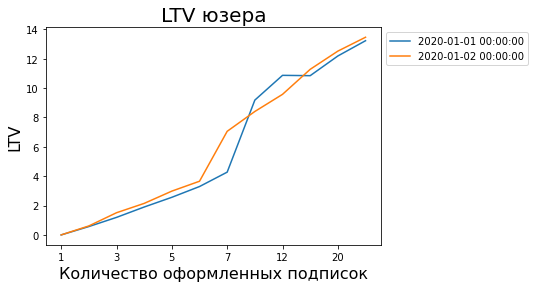

In [ ]:
ltv_8_other = ltv_8.T
# график
ltv_8_other.plot()
plt.xlabel('Количество оформленных подписок', fontsize=16)
plt.ylabel('LTV', fontsize=16)
plt.title('LTV юзера', fontsize=20)
plt.legend(bbox_to_anchor=(1, 1))

Как видим, LTV первых двух когорт через полгода будет находиться примерно на одном уровне. Построим кривую фактического LTV на фоне кривой прогнозируемого LTV.

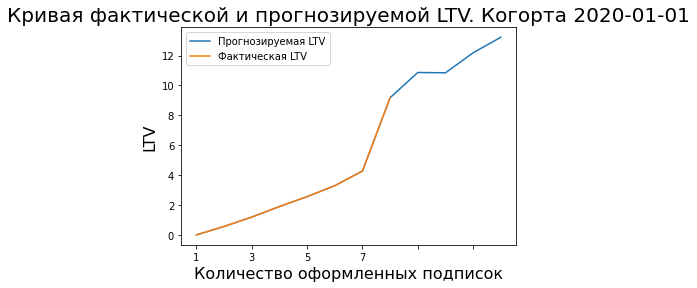

In [ ]:
# кривая фактического LTV на фоне кривой прогнозируемого LTV 
ltv_8_other['2020-01-01'].plot()
df_ltv_other['2020-01-01'].plot()
plt.xlabel('Количество оформленных подписок', fontsize=16)
plt.ylabel('LTV', fontsize=16)
plt.title('Кривая фактической и прогнозируемой LTV. Когорта 2020-01-01', fontsize=20)
plt.legend(bbox_to_anchor=(1, 1))
plt.legend(['Прогнозируемая LTV', 'Фактическая LTV']);

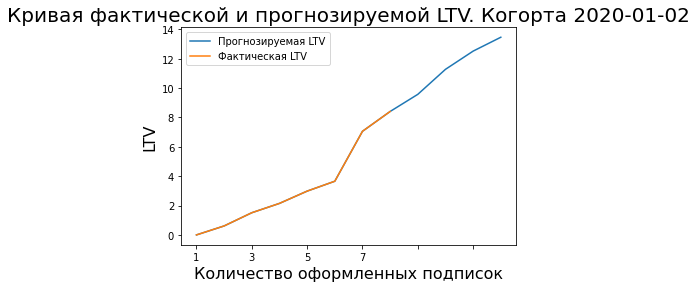

In [ ]:
# кривая фактического LTV на фоне кривой прогнозируемого LTV 
ltv_8_other['2020-01-02'].plot()
df_ltv_other['2020-01-02'].plot()
plt.xlabel('Количество оформленных подписок', fontsize=16)
plt.ylabel('LTV', fontsize=16)
plt.title('Кривая фактической и прогнозируемой LTV. Когорта 2020-01-02', fontsize=20)
plt.legend(bbox_to_anchor=(1, 1))
plt.legend(['Прогнозируемая LTV', 'Фактическая LTV']);

Таким образом график показывает дальнейший рост LTV пользователей первой и второй когорт с некоторыми отличаями. Так прогнозируемая LTV второй когорты постоянно растет, в то время как LTV первой когорты имеет этап отсутсвия роста в четвертом месяце.

## Расчет ROMI

Рассчитаем ROMI на 4 недели и на полгода, если стоимость привлечения платящего пользователя 6 USD.

In [ ]:
print('ROMI когорт 2020-01-01 и 2020-01-02 за 4 недели:')
display((df_cumsum_8['4']-(df_cumcount_8['4']*6))/(df_cumcount_8['4']*6)*100)

print('ROMI когорт 2020-01-01 и 2020-01-02 за полгода:')
(df_cumsum_8['24']-(df_cumcount_8['24']*6))/(df_cumcount_8['24']*6)*100

ROMI когорт 2020-01-01 и 2020-01-02 за 4 недели:


first_date
2020-01-01   -68.340654
2020-01-02   -64.225796
Name: 4, dtype: float64

ROMI когорт 2020-01-01 и 2020-01-02 за полгода:


first_date
2020-01-01    120.418098
2020-01-02    124.352994
Name: 24, dtype: float64

Таким образом, ROMI через полгода показывает, что пользователи первых двух когорт начинают приносить выгоду, в то время как после первого месяца когорта себя не окупает.

## Вывод

<div style="border-radius: 15px; border: 3px solid green; padding: 15px;">

Итак, имеющиеся данные были распределены по когортам, сформированным с учетом того, когда пользователь оформил пробную подписку. Для всех из них был рассчитан LTV юзера как текущий, так и по каждой неделе. Для каждой когорты с помощью линейной регрессии можно спрогнозировать LTV. В данном случае сделан прогноз для первых двух когорт и построен график, отображающий кривую фактического LTV на 
фоне кривой прогнозируемого LTV. Также рассчитан ROMI на 4 недели и на полгода для первых двух когорт: -68 и 120 для первой когорты и -64 и 124 для второй когорты.